## Ciência de Dados e Analytics - PUC-RIO
### Sprint: Análise de Dados e Boas Práticas (40530010055_20240_01)
### Aluno: Andrieles de Souza Rodrigues
### MVP: Classificação

Dataset: apple_quality.csv

Fonte do dataset: https://www.kaggle.com/datasets/sohaibmoradi/almond-types-classification

## Sobre o dataset

O dataset utilizado neste arquivo foi obtido no Kaggle e foi publicado sob a licença [CC0](https://creativecommons.org/publicdomain/zero/1.0/). Nele, encontramos 2802 registros com atributos que podem ser utilizados para identificar três variedades de amêndoas. Os atributos foram obtidos através de uma técnica de processamento de imagem ou derivadas delas e descrevem a amêndoa dimensionalmente.

Os atributos são:

| Nome do Atributo | Descrição do Atributo |
|------------------------|-----------------------------|
| Length (major axis) | Comprimento da amêndoa na imagem (com base no número de pixels) |
| Width (minor axis)    | Largura da amêndoa na imagem (com base no número de pixels) |
| Thickness (depth) | Espessura da amêndoa na imagem (com base no número de pixels) |
| Area                    | Área da região da amêndoa detectada na imagem |
| Perimeter               | Comprimento total do contorno da amêndoa |
| Roundness           | Circularidade da amêndoa: 4 * área / ( π * comprimento ** 2) |
| Solidity                 | Área / área_convexa |
| Compactness             | perímetro**2 / (4 * π * área) |
| Aspect Ratio    | Comprimento / Largura |
| Eccentricity          | sqrt(1 - ( Largura / Comprimento ) **2 ) |
| Extent                | Área / área_bbox (caixa delimitadora) |
| Convex hull(convex area) | Menor conjunto convexo que contém os pontos delimitadores |
| Type (TARGET)                   | Tipo de Amêndoa |



Nosso objetivo neste trabalho é criar um classificador que, com base nos atributos de dimensionalidade da amêndoa, possa determinar seu tipo (target).

## Carga dos modulos python e dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier # algoritmo RF (ensemble)

from sklearn.preprocessing import MinMaxScaler # normalização

from typing_extensions import DefaultDict #para acessar raw online

In [3]:

# Carga do dataset para um Dataframe

url_dataset = 'https://raw.githubusercontent.com/Andrieles/datascience/main/datasets/Almond.csv'

df = pd.read_csv(url_dataset,sep=',')

df.head()

,Unnamed: 0,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA


## Análise exploratória

In [4]:
df.shape

(2803, 14)


Análise: Para começar, podemos ver que o dataframe possui **14 colunas** e **2803 registros**.


In [5]:
df.dtypes

,0
Unnamed: 0,int64
Length (major axis),float64
Width (minor axis),float64
Thickness (depth),float64
Area,float64
Perimeter,float64
Roundness,float64
Solidity,float64
Compactness,float64
Aspect Ratio,float64


Análise: O primeiro atributo da tabela será descartado, pois se trata de um índice que não tem importância para o nosso trabalho. Os atributos de ponto flutuante são nossos atributos preditores. O último atributo é nosso target e representa o tipo de amêndoa.

In [6]:
df.describe()

,Unnamed: 0,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area)
count,2803.000000,1946.000000,1861.000000,1799.000000,2803.000000,2803.000000,1946.000000,2803.000000,2803.000000,1004.000000,1004.000000,2803.000000,2803.000000
mean,1401.000000,290.609274,171.025915,109.705378,26511.117374,743.863770,0.470466,0.955828,1.825233,1.753216,0.813114,0.724587,27696.218159
std,809.300727,62.719433,29.916529,18.940597,13782.561344,230.632076,0.118673,0.039596,0.794058,0.206616,0.041312,0.047474,14237.347610
min,0.000000,151.335266,88.050529,59.494278,6037.000000,311.563489,0.173748,0.718772,1.164469,1.400082,0.699897,0.454538,6355.000000
25%,700.500000,245.966293,149.453659,97.091682,16211.500000,571.730009,0.384810,0.944579,1.357398,1.612490,0.784476,0.701673,17088.500000
50%,1401.000000,279.879883,170.168365,110.280136,23440.500000,707.487369,0.472718,0.970422,1.576412,1.705716,0.810120,0.733720,24589.000000
75%,2101.500000,330.508575,190.640427,121.392773,33451.000000,878.896530,0.577553,0.981484,1.965953,1.833339,0.838141,0.757551,34863.250000
max,2802.000000,515.352478,258.569794,181.845200,89282.000000,1864.947387,0.697293,0.992889,9.660057,2.731251,0.930563,0.845813,90642.500000


Análise: A contagem de registros está diferente de 2803 em algumas colunas, o que deve indicar a existência de valores nulos. É possível notar também que há uma diferença nas proporções, o que parece adequado à natureza dos diversos tipos de medições realizadas para obtenção dos dados. Abaixo, vou visualizar esses dados em histogramas e um boxplot. Vamos tentar visualizar como estão distribuídos.

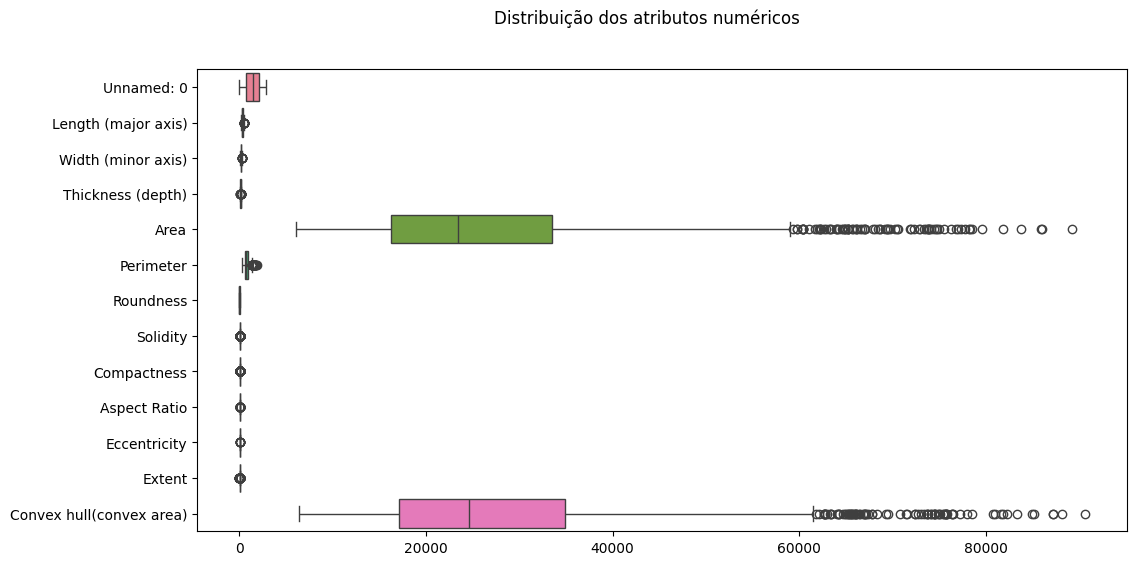

In [7]:
# Definir o tamanho da figura
plot1 = plt.figure(figsize=(12, 6))  # Ajuste os valores conforme necessário

# Título do gráfico
plot1.suptitle('Distribuição dos atributos numéricos')

# Criar o boxplot na horizontal
sns.boxplot(data=df, orient='h')

# Exibir o gráfico
plot1.show()

Análise: A distribuição dos dados também não me surpreende. Muitos valores extrapolam com bastante intensidade os quartis, principalmente os atributos que medem a área do objeto (amêndoa).

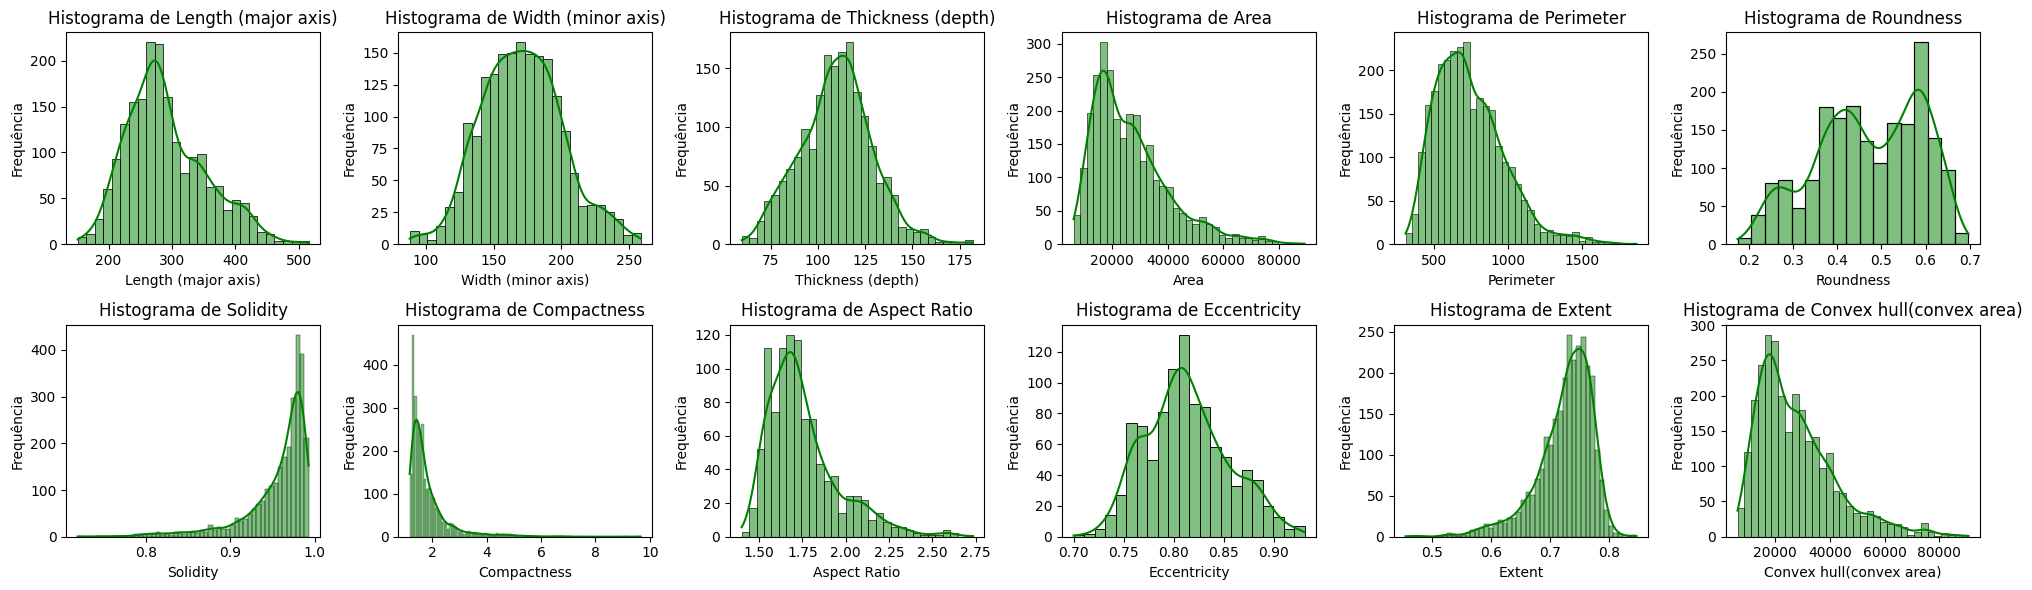

In [8]:
# Seleciona as colunas do tipo float64
float_columns = df.select_dtypes(include=['float64']).columns

# Define o número de colunas para a grade de subplots
num_cols = 6
num_rows = (len(float_columns) + num_cols - 1) // num_cols

# Cria a figura e os eixos para os subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 3 * num_rows))

# Achata a matriz de eixos para facilitar a iteração
axes = axes.flatten()

# Itera sobre as colunas e os eixos
for i, column in enumerate(float_columns):
    sns.histplot(df[column], kde=True, ax=axes[i], color='green')
    axes[i].set_title(f'Histograma de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequência')

# Remove eixos não utilizados
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajusta o layout e exibe os histogramas
plt.tight_layout()
plt.show()


Análise: Verificando os histogramas acima relativos aos valores dos atributos preditores, dá para concluir que, em grande parte, eles não possuem uma distribuição normal. Vou optar por fazer uma normalização sem padronização.

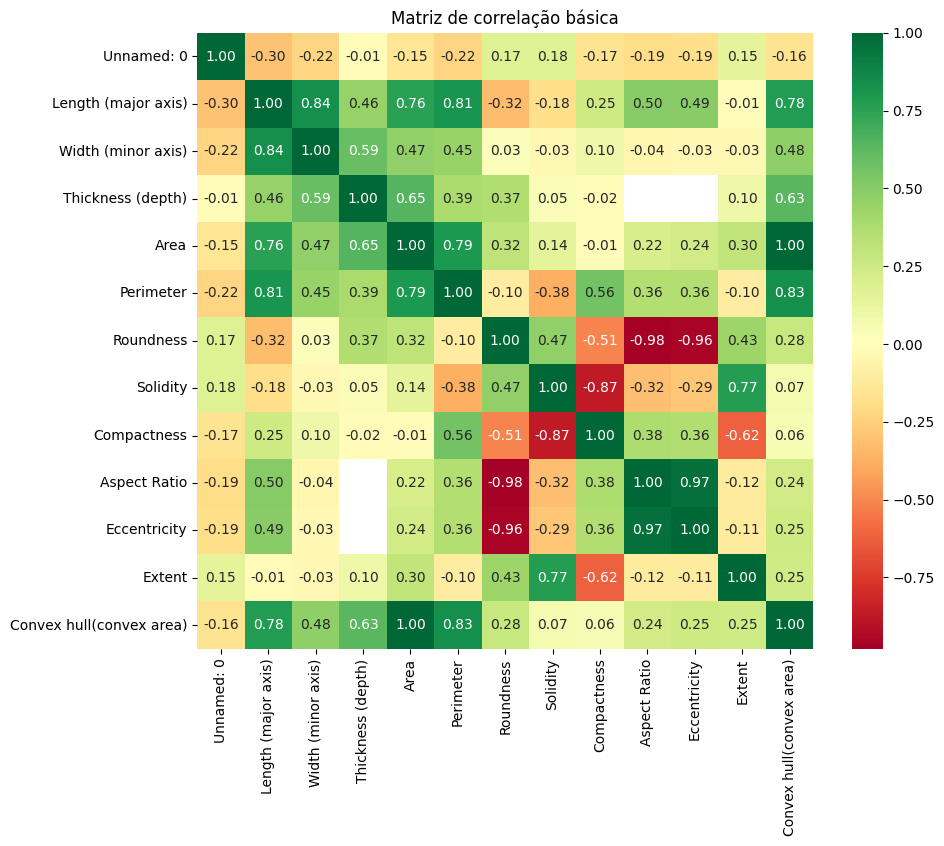

In [9]:
# Calcular a matriz de correlação
corr_matrix = df.corr(numeric_only=True)

# Criar um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlGn', square=True)

# Definir título
plt.title('Matriz de correlação básica')
plt.show()

Análise: Tratando-se de dados relativos às dimensões de um objeto orgânico, novamente não fico surpreso com os resultados da matriz de correlação. A maioria dos dados tem uma correlação forte positiva. As que têm correlação forte negativa são poucas e bem próximas de -1. Continuo propenso a fazer uma normalização sem padronização.

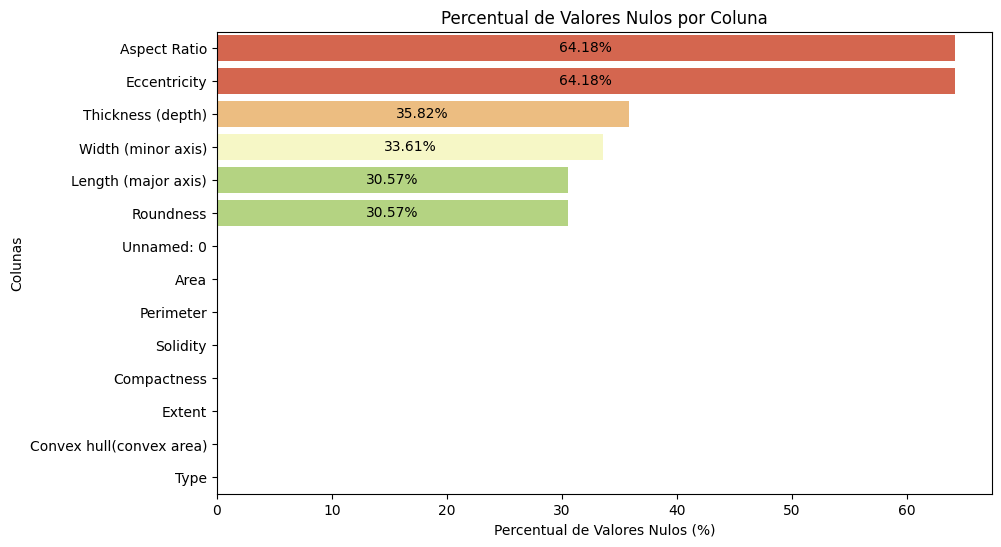

In [10]:
# calcular a porcentagem de valores nulos em cada coluna
null_percentages = df.isnull().mean() * 100

# classificar em ordem decrescente
null_percentages = null_percentages.sort_values(ascending=False)

# Criar o gráfico de colunas
plt.figure(figsize=(10, 6))

# Arredondar as porcentagens para dois decimais
null_percentages_rounded = [round(p, 2) for p in null_percentages]

# Criar uma paleta de cores baseada na classificação das porcentagens
ranks = null_percentages.rank(method='dense', ascending=False).astype(int)
colors = sns.color_palette("RdYlGn", ranks.max())
palette = [colors[i - 1] for i in ranks]

# Criar o gráfico de barras com a paleta de cores
ax = sns.barplot(x=null_percentages.values, y=null_percentages.index, palette=palette)

# Adicionar títulos e rótulos
plt.title('Percentual de Valores Nulos por Coluna')
plt.xlabel('Percentual de Valores Nulos (%)')
plt.ylabel('Colunas')

# Adicionar rótulos de percentual acima das colunas
for p in ax.patches:
    if p.get_width() > 0:  # Exibir apenas se o valor for maior que 0
        ax.annotate(f'{p.get_width():.2f}%',
                    (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')

# Exibir o gráfico
plt.show()

# identifica colunas para drop posterior
columns_to_drop = null_percentages[null_percentages > 60].index


Análise: Esses dados me surpreenderam agora. Duas colunas excedem os 64% de nulidade. Estou tentado a excluir esses atributos. Para resolver os campos nulos de forma geral, vou optar por substituí-los pela média dos atributos. Usar uma mediana pode propagar uma característica de um objeto específico para o conjunto, e isso não me parece adequado.

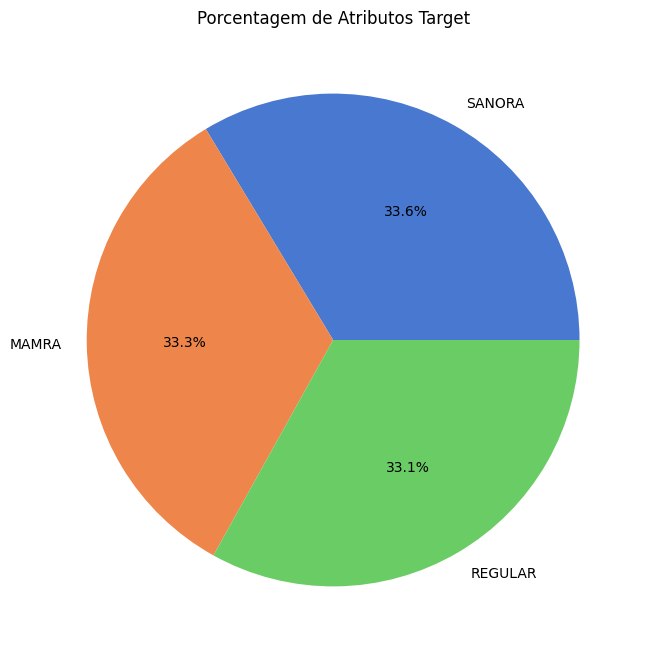

In [11]:
# Calcular a porcentagem de cada categoria
porcentagem = df['Type'].value_counts(normalize=True) * 100

# Transformar em DataFrame
df_porcentagem = porcentagem.reset_index()
df_porcentagem.columns = ['categoria', 'porcentagem']

# Criar o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(df_porcentagem['porcentagem'], labels=df_porcentagem['categoria'], autopct='%1.1f%%', colors=sns.color_palette("muted", len(df_porcentagem)))
plt.title('Porcentagem de Atributos Target')
plt.show()

Análise: Finalmente, nosso atributo target. Três valores definitivamente bem distribuídos entre os registros do dataset.

## Pré-processamento

In [12]:
# Remove a coluna 'Unnamed: 0'

df_ajustado = df.drop('Unnamed: 0', axis=1)

Descrição: A primeira operação que realizei foi a exclusão do atributo “Unnamed: 0”. Essa coluna é um índice que não é necessário para o treinamento do classificador. Nesse ponto, criei um dataframe à parte para os ajustes.

In [13]:
# Substituindo valores nulos pela média

# Selecionando apenas as colunas do tipo float64
float_cols = df_ajustado.select_dtypes(include=['float64']).columns

# Substituindo os valores nulos pela média de cada coluna
df_ajustado[float_cols] = df_ajustado[float_cols].apply(lambda x: x.fillna(x.mean()))

# df_ajustado.head(30)

Descrição: A segunda operação é o tratamento dos valores nulos. Decidi fazer a substituição dos valores nulos por médias, conforme ponderações feitas na análise de dados.

In [14]:
# Fazendo uma cópia profunda do dataframe
df_normalizado = df_ajustado.copy(deep=True)

Descrição: Nesse ponto, decidi criar outro dataframe a partir do dataframe com os ajustes anteriores. A ideia é treinar o classificador com os dados normalizados e não normalizados e comparar a acurácia de ambos.

In [15]:
# Selecionando apenas colunas do tipo float64
float_cols = df_normalizado.select_dtypes(include=['float64']).columns

# Aplicando Min-Max Scaler
scaler = MinMaxScaler()
df_normalizado[float_cols] = scaler.fit_transform(df_normalizado[float_cols])

Descrição: Aqui, eu faço a normalização dos dados de ponto flutuante em apenas um dataframe (df_normalizado), conforme considerações feitas na fase de análise exploratória.

In [16]:
# Fazendo uma cópia profunda do dataframe
df_dropado = df_normalizado.copy(deep=True)

Descrição: Nesse ponto, decidi ramificar os dataframes mais uma vez. Desta vez, a partir do dataframe normalizado, criei um dataframe do qual vou remover as colunas de atributos que possuíam mais de 60% de valores nulos. Vou treinar o classificador com esse arquivo e comparar com a acurácia dos outros dois.

In [17]:
# remover as colunas
df_dropado = df_dropado.drop(columns=columns_to_drop)

Descrição: Aqui, eu excluo as colunas com mais de 60% de nulidade. O valor de “columns_to_drop” foi definido na fase de análise exploratória para reaproveitar o código que apura os atributos com maior nulidade.

## Treino do classificador

In [18]:

## Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=42) # faz o particionamento em 10 folds

# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(42)

# Listas para armazenar os modelos e os nomes
models = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)))
models.append(('ExtraTrees', ExtraTreesClassifier()))

# Cria um dicionário para guardar os resultados médios para gráfico final
data = {
    'Categoria': [],
    'Valor': [],
    'Grupo': []
}

Descrição: Aqui, eu defino dicionários e parametros para o treinamento. Vou usar cinco moldelos e farei o parcionamento dos dados em 10 folds.

In [19]:
# Separação em bases de treino e teste (holdout)
array = df_ajustado.values

# Na escolha dos atributo estou desconsiderando a coluna 'A_id' pois não é relevante para o treinamento.
X = array[:,0:12] # atributos
y = array[:,12] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # faz a divisão


# Listas para armazenar os resultados
results = []

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  # names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)
  data['Categoria'].append(name)
  data['Valor'].append(cv_results.mean())
  data['Grupo'].append('Sem normalização')


KNN: 0.483500 (0.021836)
CART: 0.763603 (0.023955)
NB: 0.500879 (0.025440)
RandomForest: 0.837181 (0.017693)
ExtraTrees: 0.860387 (0.017630)


Descrição: Aqui, eu faço o treinamento dos modelos com base no dataframe com pré-processamento básico. Isto é, sem normalização e exclusão de colunas com alta nulidade.

In [20]:
# Separação em bases de treino e teste (holdout)
array = df_normalizado.values

# Na escolha dos atributo estou desconsiderando a coluna 'A_id' pois não é relevante para o treinamento.
X = array[:,0:12] # atributos
y = array[:,12] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # faz a divisão

# Listas para armazenar os resultados
results = []

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)
  data['Categoria'].append(name)
  data['Valor'].append(cv_results.mean())
  data['Grupo'].append('Normalizado')

KNN: 0.789921 (0.031380)
CART: 0.763605 (0.026217)
NB: 0.559778 (0.032581)
RandomForest: 0.837629 (0.017781)
ExtraTrees: 0.868853 (0.017158)


Descrição: Aqui, eu faço o treimanato com o dataframe normalizado, mas sem exclusão de atributos com alta nulidade.

In [21]:
# Separação em bases de treino e teste (holdout)
array = df_dropado.values

# Na escolha dos atributo estou desconsiderando a coluna 'A_id' pois não é relevante para o treinamento.
X = array[:,0:10] # atributos
y = array[:,10] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # faz a divisão

# Listas para armazenar os resultados
results = []

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)
  data['Categoria'].append(name)
  data['Valor'].append(cv_results.mean())
  data['Grupo'].append('Excluidos(Nulos > 60)')

KNN: 0.787698 (0.027384)
CART: 0.744853 (0.030514)
NB: 0.541946 (0.030405)
RandomForest: 0.835403 (0.022687)
ExtraTrees: 0.862603 (0.022286)


Descrição: Finalmente, nesta etapa, eu faço o treinamento do modelo usando o dataframe normalizado e com exclusão dos atributos com alta nulidade (acima de 60%).

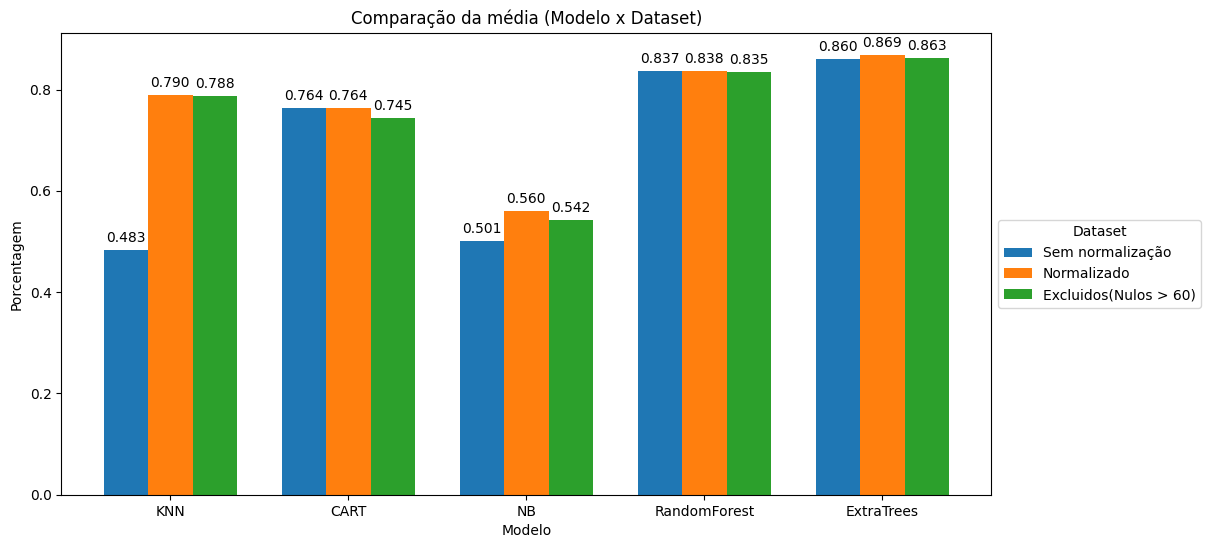

In [22]:
# Criando dataframe para criação do gráfico
result_data = pd.DataFrame(data)

# Configurando o gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Obtendo categorias e grupos únicos
categorias = result_data['Categoria'].unique()
grupos = result_data['Grupo'].unique()

# Definindo a largura das barras
bar_width = 0.25

# Definindo as posições das barras
bar_positions = np.arange(len(categorias))

# Plotando as barras para cada grupo
for i, grupo in enumerate(grupos):
    valores = result_data[result_data['Grupo'] == grupo]['Valor']
    ax.bar(bar_positions + i * bar_width, valores, width=bar_width, label=grupo)

# Adicionando os valores no topo das colunas
for i, grupo in enumerate(grupos):
    valores = result_data[result_data['Grupo'] == grupo]['Valor']
    for j, valor in enumerate(valores):
        ax.text(bar_positions[j] + i * bar_width, valor + 0.01, f'{valor:.3f}', ha='center', va='bottom')

# Ajustando labels e exibindo gráfico
ax.set_xlabel('Modelo')
ax.set_ylabel('Porcentagem')
ax.set_title('Comparação da média (Modelo x Dataset)')
ax.set_xticks(bar_positions + bar_width * (len(grupos) - 1) / 2)
ax.set_xticklabels(categorias)
ax.legend(title='Dataset', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Observação, não usei o Seaborn nesse último gráfico por conta de um bug
# na renderização que incluia um "0.00" sem explicação e eventualmente poderia
# causar uma leitura equivocada.

Descrição: Nesta última etapa, compilo o resultado do treinamento com base nos nossos três dataframes em um gráfico de barras. Abaixo, faço a análise dos resultados.

### Analise da acurácia dos modelos baseado nos três dataframes: 📊

Basicamente, os modelos baseados em ensemble de árvores de decisão se saíram melhor nos três tipos de pré-processamento que fizemos, com o ExtraTrees tendo a melhor acurácia média entre todos, utilizando dados normalizados sem exclusão de nulidades. Outro modelo que se destaca, mesmo não tendo a melhor acurácia, é o KNN, que deu um salto nos resultados com o uso de dados normalizados.


## Considerações finais do trabalho:

Este trabalho reflete para mim a complexidade e os desafios enfrentados na construção de um classificador eficiente. Utilizando este dataset obtido no Kaggle, composto por atributos dimensionais de amêndoas, foi possível explorar diversas técnicas de análise exploratória, pré-processamento e um pouco de modelagem.

Inicialmente, a análise exploratória revelou a presença de valores nulos e a necessidade de normalização dos dados, devido à ausência de distribuição normal em muitos atributos. A decisão de substituir valores nulos pela média dos atributos foi fundamentada na tentativa de evitar a propagação de características específicas de um objeto para o conjunto de dados.

A exclusão de atributos com mais de 60% de nulidade e a normalização dos dados foram etapas cruciais para melhorar a qualidade do dataset. A criação de diferentes dataframes permitiu a comparação entre modelos treinados com dados brutos, normalizados e com exclusão de atributos de alta nulidade.

Os resultados mostraram que um bom trabalho de pré-processamento pode mudar radicalmente a performance de um modelo.

Em conclusão, este trabalho demonstrou a importância do pré-processamento embasado por uma análise exploratória de dados adequada para a construção de classificadores eficientes. As técnicas aplicadas e os resultados obtidos fornecem uma base sólida para futuras pesquisas e aprimoramentos na minha carreira na área de análise de dados.
